In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [3]:
# Load data
df = pd.read_csv('ETH-USD.csv')     # Example ETH-USD

# Show first few rows
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [4]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index and sort
df.set_index('Date', inplace=True)
df = df.sort_index()

# Drop missing values
df = df.dropna()

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984


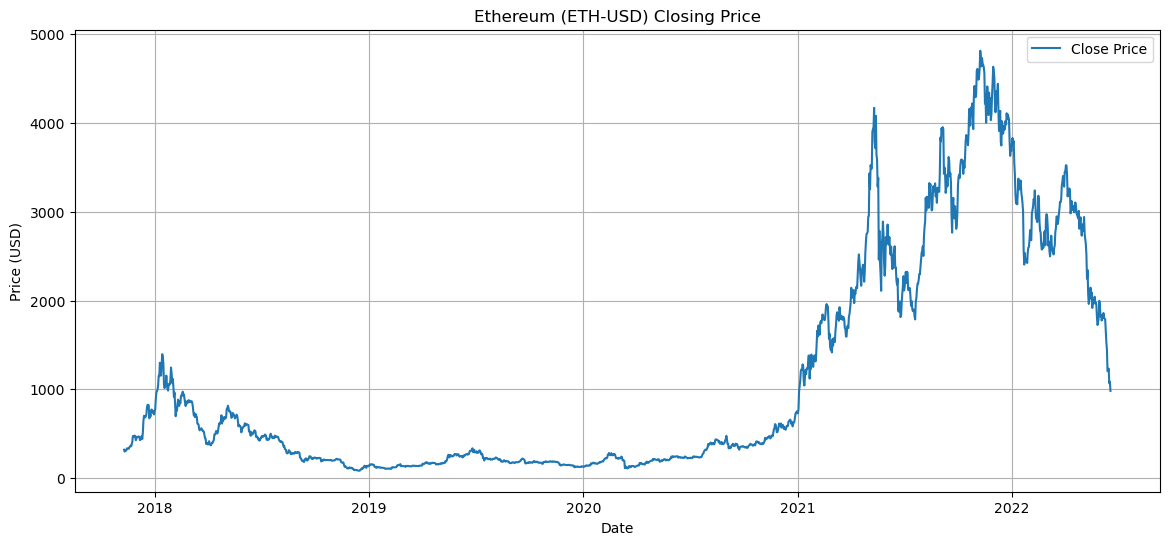

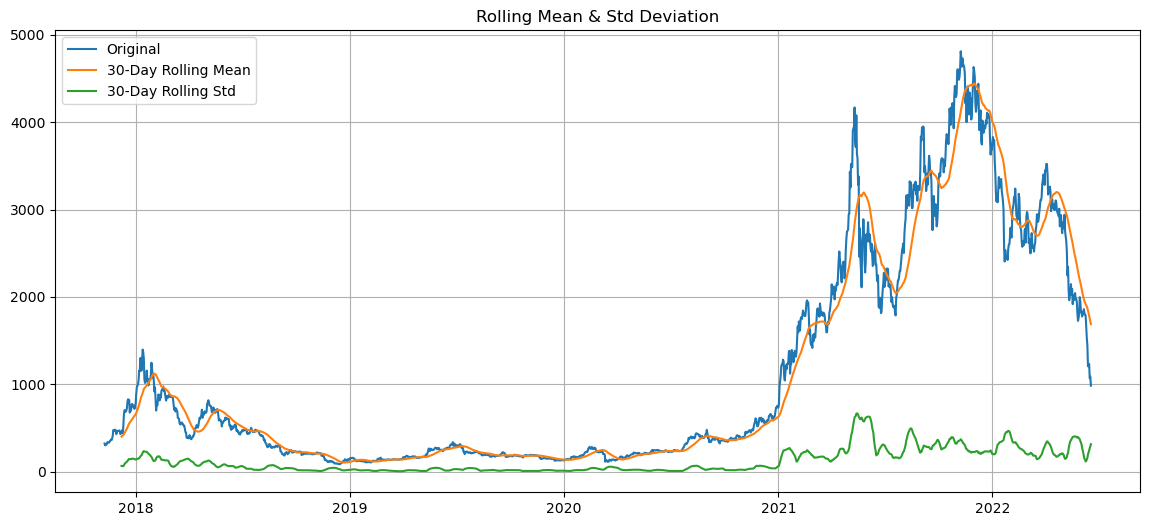

In [5]:
# Plot Closing Price
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.title('Ethereum (ETH-USD) Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Rolling Mean and Std
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='30-Day Rolling Mean')
plt.plot(rolling_std, label='30-Day Rolling Std')
plt.legend()
plt.title('Rolling Mean & Std Deviation')
plt.grid()
plt.show()


In [6]:
# ADF Test on original data
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Difference the series if not stationary
df['Close_diff'] = df['Close'].diff()

# Drop NA created by differencing
df.dropna(inplace=True)

# ADF Test on differenced data
result_diff = adfuller(df['Close_diff'])
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])


ADF Statistic: -1.3200256046080765
p-value: 0.6199615082922689
ADF Statistic (Differenced): -9.916659717026691
p-value (Differenced): 3.06725672967839e-17


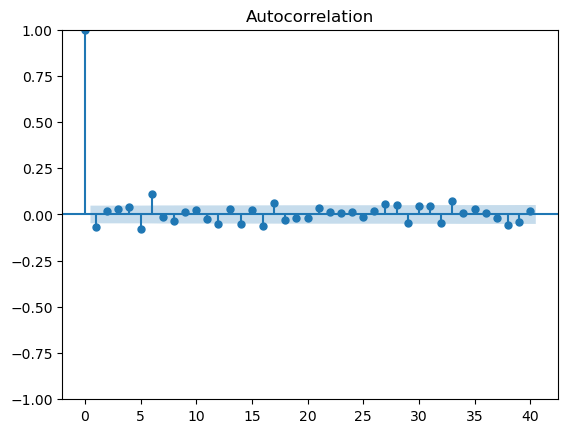

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


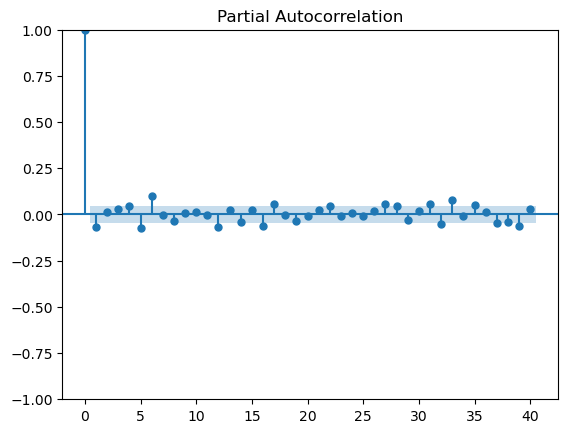

In [7]:
plot_acf(df['Close_diff'], lags=40)
plt.show()

plot_pacf(df['Close_diff'], lags=40)
plt.show()


In [8]:
model = auto_arima(df['Close'], seasonal=False, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19530.625, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19533.102, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19527.952, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19528.184, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19531.145, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19529.699, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19529.818, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19529.765, Time=1.99 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=19526.002, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=19527.747, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=19527.866, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=19526.234, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=19527.804, Time=0.69 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.924 seconds
         

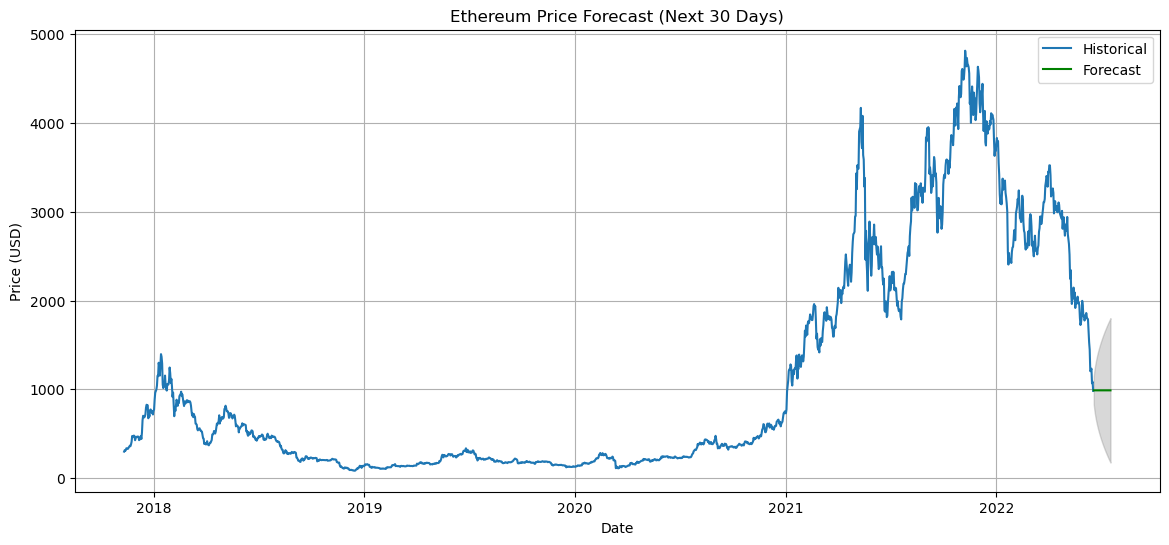

In [9]:
n_periods = 30
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_periods)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_index)

# Plot forecast
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Historical')
plt.plot(forecast_df['Forecast'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='gray', alpha=0.3)
plt.title('Ethereum Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()
